In [1]:
import json
import xmltodict as xtd
import numpy as np
import os
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import PorterStemmer
from joblib import Parallel, delayed
from gensim import corpora
from gensim import models
import pandas as pd
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, Similarity
from operator import itemgetter
import glob
from matplotlib import pyplot as plt

In [2]:
path_queries = r"B:\document_parser\document_parses\topics-rnd5.xml"
path_texts = "B:\document_parser\document_parses\pdf_json"
path_test = "B:/document_parser/document_parses/test"
path_judgements = "B:/document_parser/document_parses/judgements.csv"
path_judgements2 = "B:/document_parser/document_parses/judgements2.csv"

# Preprocessing

## Creación del Diccionario

In [21]:
dictionary = corpora.Dictionary(line.split() for line in open("docs.txt","r"))
dictionary.save('covid19.dict')  # store the dictionary, for future reference
print(dictionary)

Dictionary(1392828 unique tokens: ['abl', 'absenc', 'absent', 'abundantli', 'accept']...)


## Creación BOW

In [22]:
stopset = set(stopwords.words("english"))

In [23]:
def preprocess_document(doc,stopset):
    title = np.array([doc["metadata"]["title"]], dtype=str)
    abstract = np.array([paragraph["text"] for paragraph in doc["abstract"]], dtype=str)
    text = np.array([paragraph["text"] for paragraph in doc["body_text"]], dtype=str)
    stemmer = PorterStemmer()
    information = np.concatenate((title, abstract, text))
    tokens = np.concatenate(([wordpunct_tokenize(inf) for inf in information]))
    clean = [token.lower() for token in tokens if token.lower() not in stopset and len(token) > 2 and not token.isnumeric()]
    final = " ".join([stemmer.stem(word) for word in clean])
    return title[0], str(final.encode("utf-8"))

In [25]:
#files = glob.glob(path_texts + "/*.json")
#with open("docs.txt", "w+") as f:
#    i = 1
 #   for file in files:
  #      print(i)
   #     i+=1
    #    with open(file) as js:
     #       file_json = json.load(js)
      #  _, stems = preprocess_document(file_json, stopset)
       # f.write(stems.strip('b\'')+"\n")

In [85]:
class MyCorpus:
    
    def __init__(self, file):
        self.path = file
        
    def __iter__(self):
        for line in open(self.path):
            # assume there's one document per line, tokens separated by whitespace
            yield dictionary.doc2bow(line.split())

In [86]:
path_corpus = "docs.txt"
bow = MyCorpus(path_corpus)
corpora.MmCorpus.serialize("covid19.mm", bow, metadata=True)
print(bow)

## Creación de la matriz de Similaridades

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
index_temp = get_tmpfile("index")
index = Similarity(index_temp, bow, num_features=len(dictionary))  # create index
index.save("covid19.index")

# Carga de datos 

## Titles

In [3]:
import dask.bag as db
from dask.distributed import Client, progress
client = Client(n_workers=6, threads_per_worker=2)

client

Client Scheduler: tcp://127.0.0.1:50859 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 12 Memory: 34.31 GB


In [4]:
def load_dataset(path):
    files = glob.glob(path + "/*.json")
    b = db.from_sequence(files).map(load_json)
    df = b.to_dataframe(columns=["id", "title", "abstract", "body"])
    return df

def load_document(doc):
    title = doc["metadata"]["title"]
    abstract = " ".join([paragraph["text"] for paragraph in doc["abstract"]])
    text = " ".join([paragraph["text"] for paragraph in doc["body_text"]])
    returned = {}
    returned["id"] = doc["paper_id"]
    returned["title"] = title
    returned["abstract"] = abstract
    returned["body"] = text
    return returned

def load_json(file_path):
    with open(file_path) as file:
        file_json = json.load(file)
    returned = load_document(file_json)
    return returned

In [5]:
dataset = load_dataset(path_texts)

In [6]:
titles = dataset[["id","title"]].compute()

In [7]:
titles

,id,title
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19
2,000379d7a7f37a2ccb978862b9f2016bd03259ea,ScienceDirect ScienceDirect Effect of Nanomate...
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...
...,...,...
15,fff8b9e88db122ffcbaf1daf6b697e44eaaffd93,Septic shock caused by Mycobacterium tuberculo...
16,fffaed7e9353b7df6c4ca8f66b62e117013cb86d,Dengue Virus Glycosylation: What Do We Know?
17,fffb268f02887d8680dc611f6fc0b20c489030cb,Emergence of novel coronavirus and progress to...
18,fffc88be66eb39823fc9b50f0683e06a3038c9fe,A fractional-order compartmental model for pre...


## Judgements

In [8]:
def load_judgements(path_judgements):
    judgements = pd.read_csv(path_judgements, delimiter=' ', names = ["query", "cord_uid", "score"], usecols=[0,2,3])
    judgements.loc[judgements['score'] < 1, 'binary_score'] = 0
    judgements.loc[judgements['score'] >=1 , 'binary_score'] = 1
    return judgements

judgements = load_judgements(path_judgements2)
judgements

,query,cord_uid,score,binary_score
0,1,005b2j4b,2,1.0
1,1,00fmeepz,1,1.0
2,1,010vptx3,2,1.0
3,1,0194oljo,1,1.0
4,1,021q9884,1,1.0
...,...,...,...,...
69313,50,zvop8bxh,2,1.0
69314,50,zwf26o63,1,1.0
69315,50,zwsvlnwe,0,0.0
69316,50,zxr01yln,1,1.0


## Queries

In [9]:
def load_queries(queries_path):
    """
    Receives the path of the queries files and returns a dictionary containing all the queries.

    Parameters
    ----------
    queries_path : path of the queries file

    Returns
    -------
    dic_judgements : dictionary

    """
    with open(queries_path, "r") as xml_file:
        data_dict = xtd.parse(xml_file.read())
    xml_file.close()

    dic_queries = {}
    for query in data_dict["topics"]["topic"]:
        dic_queries[query["@number"]] = query["query"]

    df = pd.DataFrame.from_dict(dic_queries, orient='index', columns=['query'])

    return df

queries = load_queries(path_queries)
queries.head()

,query
1,coronavirus origin
2,coronavirus response to weather changes
3,coronavirus immunity
4,how do people die from the coronavirus
5,animal models of COVID-19


## Metadata

In [10]:
path_metadata = "B:/document_parser/document_parses/metadata.csv"

In [11]:
metadata = pd.read_csv(path_metadata, header = 0, usecols = [0,1])

In [12]:
metadata = metadata.assign(sha=metadata.sha.str.split('; ')).explode('sha')
metadata

,cord_uid,sha
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32
...,...,...
320513,jwp8f10m,fc8e76ad02e87bd7d66d5e952a23d1d15480e27c
320514,r21k0gku,c7c88bf0abd741c2969d03f55373a729ddfcd802
320515,jx8wulcg,a183646896ed073a4ec4035c5b6c6c77db89f0b3
320516,q1fzxt3r,c4e99c8b861f4457b4a0518860bc9e52f5348e87


In [13]:
metadata['sha'].isnull().values.sum()

204463

In [14]:
metadata = metadata.dropna()

# Trabajo

## TFIDF Model

In [15]:
bow = corpora.MmCorpus('covid19.mm')

In [16]:
dictionary = corpora.Dictionary.load("covid19.dict")

In [17]:
similarities = Similarity.load("covid19.index")

In [18]:
model_tfidf = models.TfidfModel(bow)

In [20]:
def launch_query_tfidf(model, dictionary, bow, index, query, titles, verbose = 0):
    stopset = set(stopwords.words("english"))
    index = index
    pq = preprocess_query_tfidf(query, stopset)
    vq = dictionary.doc2bow(pq)
    qtfidf = model[vq]
    sim = index[qtfidf]
    ranking = sorted(enumerate(sim), key=itemgetter(1), reverse=True)
    if verbose:
        for doc, score in ranking[:5]:
            print("[ Score = " + "%.3f" % round(score,3) + " ] " + titles['title'].iloc[doc])
    return ranking, sim
        
def preprocess_query_tfidf(query, stopset):
    stemmer = PorterStemmer()
    tokens = wordpunct_tokenize(query)
    clean = [token.lower() for token in tokens if token.lower() not in stopset and len(token) > 2]
    stems = [stemmer.stem(word) for word in clean]
    return stems

In [21]:
ranking, sim = launch_query_tfidf(model_tfidf, dictionary, bow, similarities, queries.iloc[0][0], titles, verbose = 1)

[ Score = 0.382 ] Characteristics of Metazoan DNA Replication Origins
[ Score = 0.360 ] Possible Bat Origin of Severe Acute Respiratory Syndrome Coronavirus 2
[ Score = 0.333 ] Journal Pre-proof Clinically Significant Fear and Anxiety of COVID-19: A Psychometric Examination of the Coronavirus Anxiety Scale
[ Score = 0.323 ] Journal Pre-proof Fatalism in the context of COVID-19: Perceiving coronavirus as a death sentence predicts reluctance to perform recommended preventative behaviors
[ Score = 0.316 ] 


### Example of evaluation

In [22]:
ranking = [[position[0], position[1]] for position in ranking]

In [23]:
ranking = pd.DataFrame(ranking, columns=["doc_position", "rel_score"])

In [24]:
ranking

,doc_position,rel_score
0,57867,0.381604
1,78990,0.360190
2,79519,0.332744
3,61289,0.322894
4,4471,0.315705
...,...,...
84415,84406,0.000000
84416,84407,0.000000
84417,84408,0.000000
84418,84409,0.000000


In [25]:
results = ranking
results["sha"] = results["doc_position"].map(lambda x: titles["id"].iloc[x])
results["ranking"] = results.index
print(results["rel_score"].mean())
#results = results[results["rel_score"]>0.008760440347593913]
results

0.01424068978318777


,doc_position,rel_score,sha,ranking
0,57867,0.381604,af71282a17e1b5f85f664ad1832f585fc29fa83b,0
1,78990,0.360190,efa8c88425a643428cdd2972aaca8c0f38040737,1
2,79519,0.332744,f13a223cf5a744477fb2259c624d52da436c5b32,2
3,61289,0.322894,b9abb25c38229bd2f5b9f418e3d83c51a9441e14,3
4,4471,0.315705,0d8a8b1f36f58232f56fa225dfd02d318c3b6433,4
...,...,...,...,...
84415,84406,0.000000,fff28c4948e827bb5efc14f075b97fa5ed7c1cf5,84415
84416,84407,0.000000,fff3678cfe3ce7a9ccae1e7becf17d5d71d1b54a,84416
84417,84408,0.000000,fff37ff9de7ac14189bacc386448ae96a624f19f,84417
84418,84409,0.000000,fff5ef42f08b25d724bfca377d6f1c88ab33664e,84418


In [26]:
results = results.set_index("sha").join(metadata.set_index("sha"))
results = results.sort_values(by=["ranking"])

In [27]:
results

,doc_position,rel_score,ranking,cord_uid
sha,,,,
af71282a17e1b5f85f664ad1832f585fc29fa83b,57867,0.381604,0,2qto9vsb
efa8c88425a643428cdd2972aaca8c0f38040737,78990,0.360190,1,12dcftwt
f13a223cf5a744477fb2259c624d52da436c5b32,79519,0.332744,2,a845az43
b9abb25c38229bd2f5b9f418e3d83c51a9441e14,61289,0.322894,3,k83zt387
0d8a8b1f36f58232f56fa225dfd02d318c3b6433,4471,0.315705,4,c7j2eoz0
...,...,...,...,...
fff28c4948e827bb5efc14f075b97fa5ed7c1cf5,84406,0.000000,84415,b59uexhr
fff3678cfe3ce7a9ccae1e7becf17d5d71d1b54a,84407,0.000000,84416,1qtqergw
fff37ff9de7ac14189bacc386448ae96a624f19f,84408,0.000000,84417,prqrvemt


In [28]:
results['cord_uid'].isnull().sum()

840

In [29]:
results = results.dropna()
results

,doc_position,rel_score,ranking,cord_uid
sha,,,,
af71282a17e1b5f85f664ad1832f585fc29fa83b,57867,0.381604,0,2qto9vsb
efa8c88425a643428cdd2972aaca8c0f38040737,78990,0.360190,1,12dcftwt
f13a223cf5a744477fb2259c624d52da436c5b32,79519,0.332744,2,a845az43
b9abb25c38229bd2f5b9f418e3d83c51a9441e14,61289,0.322894,3,k83zt387
0d8a8b1f36f58232f56fa225dfd02d318c3b6433,4471,0.315705,4,c7j2eoz0
...,...,...,...,...
fff28c4948e827bb5efc14f075b97fa5ed7c1cf5,84406,0.000000,84415,b59uexhr
fff3678cfe3ce7a9ccae1e7becf17d5d71d1b54a,84407,0.000000,84416,1qtqergw
fff37ff9de7ac14189bacc386448ae96a624f19f,84408,0.000000,84417,prqrvemt


In [30]:
judgements_parcial = judgements[judgements["query"] == 1]
judgements_parcial

,query,cord_uid,score,binary_score
0,1,005b2j4b,2,1.0
1,1,00fmeepz,1,1.0
2,1,010vptx3,2,1.0
3,1,0194oljo,1,1.0
4,1,021q9884,1,1.0
...,...,...,...,...
1642,1,zv0ysi8m,1,1.0
1643,1,zxvim4t8,0,0.0
1644,1,zy8qjaai,1,1.0
1645,1,zz24hrva,1,1.0


In [31]:
statistics = results.set_index("cord_uid").join(judgements_parcial.set_index("cord_uid"))
statistics

,doc_position,rel_score,ranking,query,score,binary_score
cord_uid,,,,,,
000ajevz,7623,0.006667,43292,NaN,NaN,NaN
000q5l5n,17269,0.000000,65252,NaN,NaN,NaN
000tfenb,66091,0.029836,11690,NaN,NaN,NaN
001u8ecb,6127,0.000000,62069,NaN,NaN,NaN
003r4sjl,24650,0.011316,32139,NaN,NaN,NaN
...,...,...,...,...,...,...
zzvmj5qy,16372,0.006720,43131,NaN,NaN,NaN
zzw7zlh6,12233,0.004560,49925,NaN,NaN,NaN
zzxjv666,57978,0.047535,5356,NaN,NaN,NaN


In [32]:
# En vez de dropear, rellanmos con 0
statistics = statistics.dropna()
#a["binary_score"].fillna(0, inplace=True)

In [33]:
statistics = statistics[statistics["rel_score"]>0]

In [34]:
statistics

,doc_position,rel_score,ranking,query,score,binary_score
cord_uid,,,,,,
005b2j4b,24564,0.099406,945,1.0,2.0,1.0
010vptx3,948,0.064816,2832,1.0,2.0,1.0
0194oljo,21873,0.028815,12308,1.0,1.0,1.0
047xpt2c,66284,0.054961,3989,1.0,0.0,0.0
047xpt2c,82390,0.031783,10631,1.0,0.0,0.0
...,...,...,...,...,...,...
zsx7wfyj,24633,0.116521,590,1.0,1.0,1.0
ztcyvsoi,51414,0.123075,484,1.0,1.0,1.0
zu46bdpu,40525,0.015517,24943,1.0,2.0,1.0


In [35]:
statistics = statistics.sort_values(by=["ranking"])

In [36]:
statistics = statistics.reset_index()

In [37]:
statistics["rank"] = statistics.index+1

In [38]:
statistics["relevant"] = statistics["binary_score"]
statistics["rel_retrieved"] = statistics["binary_score"].cumsum()
statistics["precision"] = statistics["rel_retrieved"] / statistics["rank"]
r = statistics["relevant"].sum()
statistics["recall"] = statistics["rel_retrieved"] / r
statistics.drop(["doc_position", "score", "binary_score"], axis=1, inplace=True)

In [39]:
statistics

,cord_uid,rel_score,ranking,query,rank,relevant,rel_retrieved,precision,recall
0,2qto9vsb,0.381604,0,1.0,1,0.0,0.0,0.000000,0.000000
1,12dcftwt,0.360190,1,1.0,2,1.0,1.0,0.500000,0.001953
2,a845az43,0.332744,2,1.0,3,0.0,1.0,0.333333,0.001953
3,k83zt387,0.322894,3,1.0,4,0.0,1.0,0.250000,0.001953
4,c7j2eoz0,0.315705,4,1.0,5,0.0,1.0,0.200000,0.001953
...,...,...,...,...,...,...,...,...,...
1252,w3catjj3,0.002467,57943,1.0,1253,0.0,511.0,0.407821,0.998047
1253,ivgwn32n,0.002382,58222,1.0,1254,0.0,511.0,0.407496,0.998047
1254,r9scxa76,0.002347,58333,1.0,1255,0.0,511.0,0.407171,0.998047
1255,3oxnox9j,0.002327,58390,1.0,1256,0.0,511.0,0.406847,0.998047


In [40]:
mavp = (statistics["precision"] * statistics["relevant"]).sum() / r
r_precision = statistics.iloc[int(r-1)].precision

print(f"Mean average precision of TFIDF model for query 1 ==> {mavp}")
print(f"R-precision of TFIDF model for query 1 ==> {r_precision}")

Mean average precision of TFIDF model for query 1 ==> 0.5458155238852109
R-precision of TFIDF model for query 1 ==> 0.56640625


In [41]:
precision = statistics["precision"].values
recall = statistics["recall"].values

In [42]:
def get_higher_precision(statistics, recall):
    index = statistics.index[statistics['recall'] >= recall].tolist()[0]
    return statistics.iloc[index:]["precision"].max()

In [43]:
precision_recall = [[recall, get_higher_precision(statistics, recall)] for recall in np.arange(0,1.1, 0.1)]
precision = [precision[1] for precision in precision_recall]
recall = [recall[0] for recall in precision_recall]

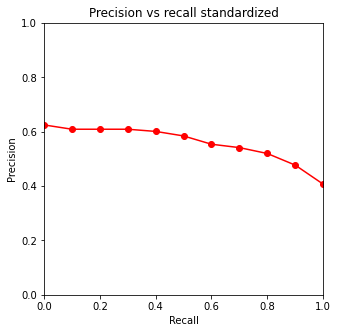

In [43]:
plt.figure(figsize=(5,5))
plt.title("Precision vs recall standardized")
plt.plot(recall, precision, "r-o")
plt.axis([0, 1, 0, 1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## TFIDF 2.0

In [44]:
model_tfidf_3 = models.TfidfModel(bow, smartirs="lpu")
model_tfidf_2 = models.TfidfModel(bow, smartirs="lfc")
model_tfidf_5 = models.TfidfModel(bow, smartirs="ltc")
model_tfidf_4 = models.TfidfModel(bow, smartirs="nnn")

# Results

In [45]:
def get_statistics_query(ranking, id_query, titles, metadata, judgements):
    ranking = [[position[0], position[1]] for position in ranking]
    ranking = pd.DataFrame(ranking, columns=["doc_position", "rel_score"])
    results = ranking
    results["sha"] = results["doc_position"].map(lambda x: titles["id"].iloc[x])
    results["ranking"] = results.index
    results = results.set_index("sha").join(metadata.set_index("sha"))
    results = results.sort_values(by=["ranking"])
    results = results.dropna()
    judgements_parcial = judgements[judgements["query"] == id_query]
    statistics = results.set_index("cord_uid").join(judgements_parcial.set_index("cord_uid"))
    statistics = statistics.dropna()
    statistics = statistics[statistics["rel_score"]>0]
    statistics = statistics.sort_values(by=["ranking"])
    statistics = statistics.reset_index()
    statistics["rank"] = statistics.index+1
    statistics["relevant"] = statistics["binary_score"]
    statistics["rel_retrieved"] = statistics["binary_score"].cumsum()
    statistics["precision"] = statistics["rel_retrieved"] / statistics["rank"]
    r = statistics["relevant"].sum()
    if r == 0:
        return {"mavp": 0, "r-precision": 0, "precision": list(np.zeros(11))}
    statistics["recall"] = statistics["rel_retrieved"] / r
    statistics.drop(["doc_position", "score", "binary_score"], axis=1, inplace=True)
    mavp = (statistics["precision"] * statistics["relevant"]).sum() / r
    r_precision = statistics.iloc[int(r-1)].precision
    precision = statistics["precision"].values
    recall = statistics["recall"].values
    precision_recall = [[recall, get_higher_precision(statistics, recall)] for recall in np.arange(0,1.1, 0.1)]
    precision = [precision[1] for precision in precision_recall]
    
    return {"mavp": mavp, "r-precision": r_precision, "precision": precision}

In [46]:
def launch(function, y,z,a,b,c):
    def h(x):
        return function(y,z,a,b,x,c)
    return h

In [47]:
def get_statistics(launch_query, queries, titles, metadata, judgements):
    results = []
    for index in range(len(queries)):
        ranking, _ = launch_query(queries.iloc[index][0])#
        result = get_statistics_query(ranking, index+1, titles, metadata, judgements)
        results.append(result)
    mavp = np.array([query["mavp"] for query in results]).mean()
    precision = np.array([query["precision"] for query in results]).mean(axis=0)
    r_precision = [query["r-precision"] for query in results]
    return {"mavp": mavp, "precision":precision, "r-precision":r_precision}

###################################################################################
Evaluating performance of our models...
-------------------------------------------------------------------------------------
Evaluating TFIDF (nfc): raw term frequency weighing, idf document frequency weighting, cosine normalization
Computing statistics...
Statistics computed...
Mean Average Precision of this model ==> 0.4982978899333098
-------------------------------------------------------------------------------------
Evaluating TFIDF (lfc): logarithmic term frequency weighing, idf document frequency weighting, cosine normalization
Computing statistics...
Statistics computed...
Mean Average Precision of this model ==> 0.4982978899333098
-------------------------------------------------------------------------------------
Evaluating TFIDF (lpu): logarithmic term frequency weighing, probabilistic document frequency weighting, pivoted unique normalization
Computing statistics...
Statistics computed...

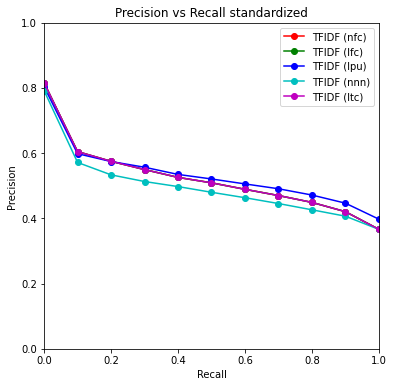

-------------------------------------------------------------------------------------
Comparing our models: TFDIF (nfc) vs TFIDF (lpu)


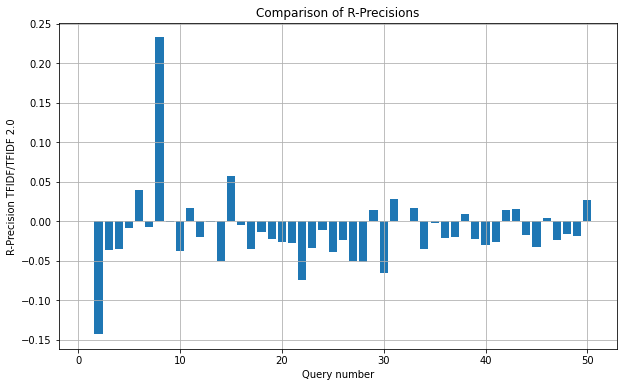

-------------------------------------------------------------------------------------
Evalution finished.
###################################################################################


In [48]:
recall = np.arange(0,1.1, 0.1)
modelos = [{"name":"TFIDF (nfc)", "term": "raw", "document": "idf", "normalization": "cosine", "model": model_tfidf, "color": "r"},
          {"name":"TFIDF (lfc)", "term": "logarithmic", "document": "idf", "normalization": "cosine", 
           "model": model_tfidf_2, "color": "g"},
           {"name":"TFIDF (lpu)", "term": "logarithmic", "document": "probabilistic", "normalization": "pivoted unique", 
           "model": model_tfidf_3, "color": "b"},
           {"name":"TFIDF (nnn)", "term": "raw", "document": "none", "normalization": "none", 
           "model": model_tfidf_4, "color": "c"},
           {"name":"TFIDF (ltc)", "term": "logarithmic", "document": "zero-corrected idf", "normalization": "cosine", 
           "model": model_tfidf_5, "color": "m"}
         ]
r_precisions = []

print("###################################################################################")
print("Evaluating performance of our models...")
plt.figure(figsize=(6,6))
plt.title("Precision vs Recall standardized")
plt.axis([0, 1, 0, 1])
plt.xlabel("Recall")
plt.ylabel("Precision")

for model in modelos:
    name = model["name"]
    term = model["term"]
    document = model["document"]
    normalization = model["normalization"]
    color = model["color"]
    print("-------------------------------------------------------------------------------------")
    print(f"Evaluating {name}: {term} term frequency weighing, {document} document frequency weighting, {normalization} normalization")
    print("Computing statistics...")
    data_tfidf = get_statistics(launch(launch_query_tfidf,model["model"], dictionary, bow, similarities, titles.copy()), queries.copy(), titles.copy(), metadata.copy(), judgements.copy())
    print("Statistics computed...")
    precision_tfidf = data_tfidf["precision"]
    mavp_tfidf = data_tfidf["mavp"]
    r_precisions.append(data_tfidf["r-precision"])
    print(f"Mean Average Precision of this model ==> {mavp_tfidf}")
    plt.plot(recall, precision_tfidf, f"{color}-o", label=name)
#print("-------------------------------------------------------------------------------------")
#print("Evaluating TFIDF 2.0: logarithmic term frequency weighing, idf document frequency weighting, cosine normalization")
#print("Computing statistics...")
#data_tfidf_2 = get_statistics(launch(launch_query_tfidf,model_tfidf_2, dictionary, bow, similarities, titles.copy()), queries.copy(), titles.copy(), metadata.copy(), judgements.copy())
#print("Statistics computed...")
#precision_tfidf_2 = data_tfidf_2["precision"]
#mavp_tfidf_2 = data_tfidf_2["mavp"]
#r_precision_tfidf_2 = data_tfidf_2["r-precision"]
#print(f"Mean Average Precision of this model ==> {mavp_tfidf_2}")
#plt.plot(recall, precision_tfidf_2, "b-o", label="TFIDF 2.0")
plt.legend()
plt.show()
print("-------------------------------------------------------------------------------------")
print("Comparing our models: TFDIF (nfc) vs TFIDF (lpu)")
r_precision = np.array(r_precisions[0]) - np.array(r_precisions[2])
# the histogram of the data
plt.figure(figsize=(10,6))
plt.bar(np.arange(1,51,1),r_precision)
plt.xlabel('Query number')
plt.ylabel('R-Precision TFIDF/TFIDF 2.0')
plt.title('Comparison of R-Precisions')
plt.grid(True)
plt.show()
print("-------------------------------------------------------------------------------------")
print("Evalution finished.")
print("###################################################################################")

## Word2Vec

In [15]:
def clean(doc):
    stopset = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    tokens = wordpunct_tokenize(doc)
    clean = [token.lower() for token in tokens if token not in stopset and len(token) > 2 and not token.isnumeric()]
    final = [stemmer.stem(token) for token in clean]
    return " ".join(final)

In [16]:
docs = pd.DataFrame((line for line in open("docs.txt")), columns = ["preprocess"])

In [17]:
queries["preprocess"] = queries["query"].apply(lambda x: clean(x))


In [18]:
combined = pd.concat((docs["preprocess"], queries["preprocess"])).sample(frac=1).reset_index(drop=True)

In [26]:
w2v_model = models.Word2Vec([i.split() for i in combined], size = 300, workers=12)

In [28]:
len(w2v_model.wv.vocab)

330933

In [30]:
word_vectors = w2v_model.wv
word_vectors.save("word2vec.wordvectors")

In [31]:
w2v_model.save("word2vec.model")

In [32]:
del w2v_model

In [19]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load("word2vec.wordvectors", mmap='r')

In [20]:
def get_embedding_w2v(doc_tokens):
    embeddings = []
    if len(doc_tokens) < 1:
        return np.zeros(300)
    else:
        for token in doc_tokens:
            if token in word_vectors.vocab:
                embeddings.append(word_vectors.word_vec(token))
            else:
                embeddings.append(np.random.rand(300))
        return np.mean(embeddings, axis = 0)
    
def get_embedding_w2v_par(doc_tokens):
    embeddings = []
    if len(doc_tokens) < 1:
        return np.zeros(300)
    embeddings = [Parallel()]
    else:
        for token in doc_tokens:
            if token in word_vectors.vocab:
                embeddings.append(word_vectors.word_vec(token))
            else:
                embeddings.append(np.random.rand(300))
        return np.mean(embeddings, axis = 0)

In [21]:
queries["embeddings"] = queries["preprocess"].apply(lambda x: get_embedding_w2v(x.split()))

In [22]:
titles = titles.reset_index(drop=True)

In [23]:
docs = titles.join(docs)

In [24]:
docs

,id,title,preprocess
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,absenc surfac express felin infecti periton vi...
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,titl rethink high risk group covid protect hig...
2,000379d7a7f37a2ccb978862b9f2016bd03259ea,ScienceDirect ScienceDirect Effect of Nanomate...,sciencedirect sciencedirect effect nanomateri ...
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,plasma inflammatori cytokin chemokin sever acu...
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,journal pre proof fire time stress racism infl...
...,...,...,...
84415,fff8b9e88db122ffcbaf1daf6b697e44eaaffd93,Septic shock caused by Mycobacterium tuberculo...,septic shock caus mycobacterium tuberculosi no...
84416,fffaed7e9353b7df6c4ca8f66b62e117013cb86d,Dengue Virus Glycosylation: What Do We Know?,dengu viru glycosyl know mani infecti diseas c...
84417,fffb268f02887d8680dc611f6fc0b20c489030cb,Emergence of novel coronavirus and progress to...,emerg novel coronaviru progress toward treatme...
84418,fffc88be66eb39823fc9b50f0683e06a3038c9fe,A fractional-order compartmental model for pre...,fraction order compartment model predict sprea...


In [56]:
import dask.dataframe as ddf
docs = ddf.from_pandas(docs, npartitions = 12)

In [58]:
docs["embeddings"] = docs["preprocess"].apply(lambda x: get_embedding_w2v(x.split()), meta=('preprocess', 'object'))

In [ ]:
docs = client.persist(docs)

In [ ]:
docs

In [ ]:
docs["embeddings"].values.compute()

In [51]:
client.restart()

Client Scheduler: tcp://127.0.0.1:53543 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 2 Memory: 5.72 GB


In [26]:
get_embedding_w2v(docs["preprocess"][0].split())

array([-6.09078177e-01,  4.07745631e-01, -7.44885512e-01, -9.22567532e-02,
        5.52799930e-01,  2.66084511e-01, -4.81817371e-02,  9.36211342e-01,
       -4.39312879e-01,  4.55677330e-01,  5.02419642e-02,  9.31901206e-02,
       -7.51115969e-01,  2.52598866e-01,  3.67409702e-01, -4.15345468e-01,
       -6.13268911e-01,  5.11757266e-01, -2.10876047e-01,  2.31704687e-01,
       -1.15349924e-01,  3.96398957e-01, -5.19221507e-01,  9.90211051e-02,
       -2.11536542e-01,  1.46748216e-02,  1.00395057e-01,  5.48738259e-01,
        2.67129112e-01,  3.94490382e-02, -1.61925406e-03, -7.61358898e-01,
        2.38310739e-01,  3.77974560e-01,  2.02269469e-01,  3.59291956e-01,
        7.24694689e-01,  1.69681020e-01,  3.76364304e-01, -6.41114554e-01,
        2.18409567e-01,  5.43548028e-01, -1.06022093e-01, -7.35662019e-02,
        3.28629240e-02, -7.15270177e-01, -3.31165542e-01, -1.65560700e-01,
        1.62005246e-01, -3.10818188e-01,  5.10185602e-02,  4.74526478e-01,
        6.28836978e-01, -

In [27]:
Parallel

joblib.parallel.Parallel

In order to reduce the amount of embeddings to be computed, we filter the documents and we only save the ones that have some query perform on it and appear in metadata.
Then, we compute the embedding for each document, so as to have it precomputed and then, when computing the similarity, just taking this value.

In [108]:
docs["sha"] = docs["id"]
inCorpus = metadata[metadata["sha"].isin(docs["sha"])]["cord_uid"]
inJudgements = inCorpus[inCorpus.isin(judgements["cord_uid"])]
filtered = metadata.loc[metadata['cord_uid'].isin(inJudgements)]["sha"].values
docs_filtered = docs.loc[docs["id"].isin(filtered)]

In [109]:
docs_filtered["prepr"]

,id,title,preprocess,sha
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,titl rethink high risk group covid protect hig...,0003793cf9e709bc2b9d0c8111186f78fb73fc04
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,plasma inflammatori cytokin chemokin sever acu...,00039b94e6cb7609ecbddee1755314bcfeb77faa
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,journal pre proof fire time stress racism infl...,0003ddc51c4291d742855e9ac56076a3bea33ad7
5,0004456994f6c1d5db7327990386d33c01cff32a,,ackground influenza immunis healthcar worker e...,0004456994f6c1d5db7327990386d33c01cff32a
7,00060fb61742ff60e4e3ba4648c74a34cfe9560d,,outbreak novel coronaviru diseas led current g...,00060fb61742ff60e4e3ba4648c74a34cfe9560d
...,...,...,...,...
84398,ffee9b5aa941373afcb67928225bda51c2ca9fb2,,march april new york citi nyc experienc expone...,ffee9b5aa941373afcb67928225bda51c2ca9fb2
84406,fff28c4948e827bb5efc14f075b97fa5ed7c1cf5,,studi epidem model develop simul past fifti da...,fff28c4948e827bb5efc14f075b97fa5ed7c1cf5
84407,fff3678cfe3ce7a9ccae1e7becf17d5d71d1b54a,Gaining Insights into the Codon Usage Patterns...,gain insight codon usag pattern tp53 gene acro...,fff3678cfe3ce7a9ccae1e7becf17d5d71d1b54a
84413,fff6fe12beb51ee2641ddb5381378ff3560d8103,Health shocks and their long-lasting impact on...,health shock long last impact health behavior ...,fff6fe12beb51ee2641ddb5381378ff3560d8103
